# EONIA curve bootstrapping

In [2]:
%matplotlib inline
import math
import QuantLib as ql

In [3]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

## First 3 instruments for day T+0, T+1, and T+2 are deposit rates

The first three instruments are three 1-day deposit that give us discounting between today and the day after spot. They are modeled by three instances of the DepositRateHelper class with a tenor of 1 day and a number of fixing days going from 0 (for the deposit starting today) to 2 (for the deposit starting on the spot date).

In [4]:
helpers = [
            ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                                 ql.Period(1,ql.Days), fixingDays,
                                 ql.TARGET(), ql.Following,
                                 False, ql.Actual360())
            for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]
        ]

## OIS rates fpr 1W, 2W, 3W and 1M

Then, we have a series of OIS quotes for the first month. They are modeled by instances of the OISRateHelper class with varying tenors. They also require an instance of the Eonia class, which doesn’t need a forecast curve and can be shared between the helpers.

In [5]:
eonia = ql.Eonia()
helpers += [
            ql.OISRateHelper(2, ql.Period(*tenor),
                             ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
            for rate, tenor in [(0.070, (1,ql.Weeks)), (0.069, (2,ql.Weeks)),
                                (0.078, (3,ql.Weeks)), (0.074, (1,ql.Months))]
        ]

## Adhoc dates in between

Next, five OIS forwards on ECB dates. For these, we need to instantiate the DatedOISRateHelper class and specify start and end dates explicitly.

In [6]:
helpers += [
            ql.DatedOISRateHelper(start_date, end_date,
                                  ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
            for rate, start_date, end_date in [
                ( 0.046, ql.Date(16,ql.January,2013), ql.Date(13,ql.February,2013)),
                ( 0.016, ql.Date(13,ql.February,2013), ql.Date(13,ql.March,2013)),
                (-0.007, ql.Date(13,ql.March,2013), ql.Date(10,ql.April,2013)),
                (-0.013, ql.Date(10,ql.April,2013), ql.Date(8,ql.May,2013)),
                (-0.014, ql.Date(8,ql.May,2013), ql.Date(12,ql.June,2013))]
        ]

## 15M to 30Y tenor pillars using OIS Rate

Finally, we add OIS quotes up to 30 years.

In [7]:
helpers += [
            ql.OISRateHelper(2, ql.Period(*tenor),
                             ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
            for rate, tenor in [(0.002, (15,ql.Months)), (0.008, (18,ql.Months)),
                                (0.021, (21,ql.Months)), (0.036, (2,ql.Years)),
                                (0.127, (3,ql.Years)), (0.274, (4,ql.Years)),
                                (0.456, (5,ql.Years)), (0.647, (6,ql.Years)),
                                (0.827, (7,ql.Years)), (0.996, (8,ql.Years)),
                                (1.147, (9,ql.Years)), (1.280, (10,ql.Years)),
                                (1.404, (11,ql.Years)), (1.516, (12,ql.Years)),
                                (1.764, (15,ql.Years)), (1.939, (20,ql.Years)),
                                (2.003, (25,ql.Years)), (2.038, (30,ql.Years))]
        ]

## Piecewise Log Cubic Discount

Curve is an instance of PiecewiseLogCubicDiscount (corresponding to the PiecewiseYieldCurve<Discount,LogCubic> class in C++; I won’t repeat the argument for this choice made in section 4.5 of the paper). We let the reference date of the curve move with the global evaluation date, by specifying it as 0 days after the latter on the TARGET calendar. The day counter chosen is not of much consequence, as it is only used internally to convert dates into times. Also, we enable extrapolation beyond the maturity of the last helper; that is mostly for convenience as we retrieve rates to plot the curve near its far end.

In [8]:
eonia_curve_c = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), helpers, ql.Actual365Fixed())


## Enable extrapolation for long date simulations

In [9]:
eonia_curve_c.enableExtrapolation()

## Plotting

In [10]:
import datetime

today = eonia_curve_c.referenceDate()
end = today + ql.Period(2,ql.Years)
ql_dates = [ ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ]
dates = [ datetime.datetime(d.year(), d.month(), d.dayOfMonth()) for d in ql_dates ]
rates_c = [ eonia_curve_c.forwardRate(d, ql.TARGET().advance(d,1,ql.Days),
                                   ql.Actual360(), ql.Simple).rate()
         for d in ql_dates ]

(array([15706., 15796., 15887., 15979., 16071., 16161., 16252., 16344.,
        16436.]),
 [Text(15706.0, 0, '2013-01'),
  Text(15796.0, 0, '2013-04'),
  Text(15887.0, 0, '2013-07'),
  Text(15979.0, 0, '2013-10'),
  Text(16071.0, 0, '2014-01'),
  Text(16161.0, 0, '2014-04'),
  Text(16252.0, 0, '2014-07'),
  Text(16344.0, 0, '2014-10'),
  Text(16436.0, 0, '2015-01')])

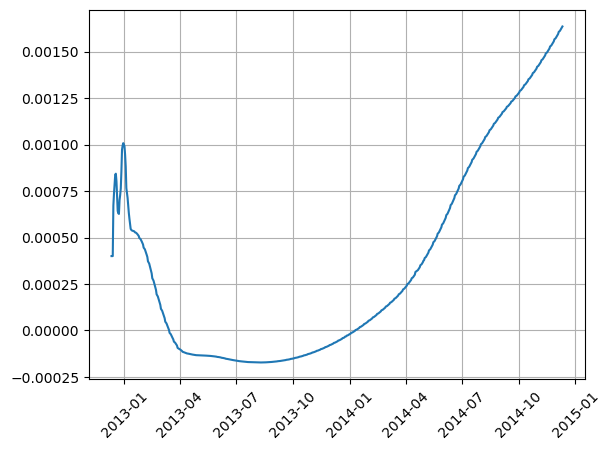

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(dates, rates_c)
ax.grid()
plt.xticks(rotation = 45)
